In [1]:
import pandas as pd
import numpy as np

/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
val = pd.read_csv("val.csv")

# preprocessing

In [ ]:
# https://www.kaggle.com/code/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re

stop_words=set(nltk.corpus.stopwords.words('english'))

In [4]:
# preprocess text: remove stop words, lemmatize, remove non-alphanumeric characters
def clean_text(text):
    le=WordNetLemmatizer()
    text = text.lower() # lowercase
    text = re.sub(r"[^A-Za-z0-9]", " ", text) # remove non alphanumeric characters
    word_tokens=word_tokenize(text)
    tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3] # remove stopwords, lemmatize
    cleaned_text=" ".join(tokens)
    return cleaned_text

In [5]:
train['text_cleaned']=train['text'].apply(clean_text)
test['text_cleaned']=test['text'].apply(clean_text)
val['text_cleaned']=val['text'].apply(clean_text)

# lda + logistic regression

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, classification_report
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression

In [9]:
# hyperparameters
num_features = 10000 # ~36k unique words (not including stop words) in train set
num_topics = 15 # try 5,10,15,20,25

# bag of words on text
vec = CountVectorizer(max_features=num_features, max_df=0.5)
vec.fit(train["text_cleaned"])

X_train = vec.transform(train["text_cleaned"]).toarray() # D x V
X_test = vec.transform(test["text_cleaned"]).toarray()
X_val = vec.transform(val["text_cleaned"]).toarray()

y_train = train["author_id"].to_numpy()
y_test = test["author_id"].to_numpy()
y_val = val["author_id"].to_numpy()

# list of feature names
bow_list = vec.get_feature_names_out()

# dictionary mapping column to word
bow_dict = vec.vocabulary_

# fit lda model
lda_model = LatentDirichletAllocation(n_components = num_topics, learning_method='online', 
                                      max_iter = 1).fit(X_train)

# get topic distribution
train_lda_topic_dist = lda_model.transform(X_train)
test_lda_topic_dist = lda_model.transform(X_test)
val_lda_topic_dist = lda_model.transform(X_val)

# train logistic regression model
logreg = LogisticRegression()
logreg.fit(train_lda_topic_dist, y_train)

# Make predictions on the val set and evaluate the model
y_pred = logreg.predict(val_lda_topic_dist)
accuracy = accuracy_score(y_test, y_pred)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

confusion_matrix(y_test, y_pred)

accuracy 0.002
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        10
          17

/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 3, 0, 0]])

In [10]:
# train accuracy
y_pred = logreg.predict(train_lda_topic_dist)
accuracy = accuracy_score(y_train, y_pred)

print('accuracy %s' % accuracy_score(y_pred, y_train))
print(classification_report(y_train, y_pred))

confusion_matrix(y_train, y_pred)

accuracy 0.344
              precision    recall  f1-score   support

           0       0.18      0.20      0.19        80
           1       0.30      0.66      0.41        80
           2       0.44      0.51      0.47        80
           3       0.38      0.69      0.49        80
           4       0.40      0.36      0.38        80
           5       0.33      0.06      0.11        80
           6       0.23      0.06      0.10        80
           7       0.40      0.61      0.49        80
           8       0.17      0.04      0.06        80
           9       0.38      0.74      0.50        80
          10       0.21      0.09      0.12        80
          11       0.42      0.44      0.43        80
          12       0.29      0.35      0.32        80
          13       0.39      0.69      0.50        80
          14       0.29      0.11      0.16        80
          15       0.15      0.11      0.13        80
          16       0.46      0.66      0.55        80
          17

array([[16,  0,  0, ..., 16,  0,  0],
       [ 0, 53,  0, ...,  0,  1,  0],
       [ 0,  6, 41, ...,  0,  4,  0],
       ...,
       [ 6,  0,  0, ..., 16,  0,  0],
       [ 0,  6, 28, ...,  0,  3,  0],
       [ 0, 14,  0, ...,  0,  0,  3]])

In [ ]:
# most important words for each topic
vocab = vec.get_feature_names()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

# lda + linear SVM

In [11]:
from sklearn.svm import LinearSVC

In [13]:
# hyperparameters
num_features = 10000 # try 1-10k? (~36k unique words (not including stop words) in train set)
num_topics = 15 # try 5,10,15,20,25?

# bag of words on text
vec = CountVectorizer(max_features=num_features, max_df=0.5)
vec.fit(train["text_cleaned"])

X_train = vec.transform(train["text_cleaned"]).toarray() # D x V
X_test = vec.transform(test["text_cleaned"]).toarray()
X_val = vec.transform(val["text_cleaned"]).toarray()

y_train = train["author_id"].to_numpy()
y_test = test["author_id"].to_numpy()
y_val = val["author_id"].to_numpy()

# list of feature names
bow_list = vec.get_feature_names_out()

# dictionary mapping column to word
bow_dict = vec.vocabulary_

# fit lda model
lda_model = LatentDirichletAllocation(n_components = num_topics, learning_method='online', 
                                      max_iter = 1).fit(X_train)

# get topic distribution
train_lda_topic_dist = lda_model.transform(X_train)
test_lda_topic_dist = lda_model.transform(X_test)
val_lda_topic_dist = lda_model.transform(X_val)

# linear svm
svm = LinearSVC()
svm.fit(train_lda_topic_dist, y_train)

# Make predictions on the val set and evaluate the model
y_pred = svm.predict(val_lda_topic_dist)
accuracy = accuracy_score(y_test, y_pred)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

confusion_matrix(y_test, y_pred)

accuracy 0.006
              precision    recall  f1-score   support

           0       0.07      0.10      0.08        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00        10
          17

/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 7, 0, 0]])

In [14]:
# train accuracy
y_pred = svm.predict(train_lda_topic_dist)
accuracy = accuracy_score(y_train, y_pred)

print('accuracy %s' % accuracy_score(y_pred, y_train))
print(classification_report(y_train, y_pred))

confusion_matrix(y_train, y_pred)

accuracy 0.36025
              precision    recall  f1-score   support

           0       0.30      0.34      0.32        80
           1       0.56      0.69      0.61        80
           2       0.45      0.66      0.54        80
           3       0.47      0.68      0.56        80
           4       0.48      0.42      0.45        80
           5       0.40      0.07      0.13        80
           6       0.17      0.01      0.02        80
           7       0.23      0.53      0.32        80
           8       0.19      0.04      0.06        80
           9       0.37      0.75      0.50        80
          10       0.25      0.07      0.12        80
          11       0.39      0.76      0.52        80
          12       0.22      0.15      0.18        80
          13       0.39      0.62      0.48        80
          14       0.14      0.04      0.06        80
          15       1.00      0.01      0.02        80
          16       0.33      0.55      0.41        80
          

/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[27,  0,  0, ..., 12,  0,  0],
       [ 0, 55,  1, ...,  0,  0,  0],
       [ 0,  2, 53, ...,  0,  4,  0],
       ...,
       [ 0,  0,  0, ..., 46,  0,  0],
       [ 0,  6, 31, ...,  5,  3,  0],
       [ 0,  6,  0, ...,  0,  0,  2]])

In [ ]:
# most important words for each topic
vocab = vec.get_feature_names()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

# supervised LDA

In [ ]:
# reference: https://github.com/bab2min/tomotopy/issues/82

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import tomotopy as tp

In [36]:
def get_labels(probs):
    labels = np.argmax(probs, axis=1)
    return labels

In [38]:
def accuracy_metrics(y_pred, y_true):
    accuracy = accuracy_score(y_true, y_pred)

    print('accuracy %s' % accuracy_score(y_pred, y_true))
    print(classification_report(y_true, y_pred))

    print(confusion_matrix(y_true, y_pred))
    return

In [129]:
def hyperparameter_tuning(train, val):
    num_topics = [i for i in range(5,51)]
    losses = [ ]
    pred_labels = [ ]
    
    labels = pd.get_dummies(train["author_id"]).astype("int").to_numpy()
    for k in num_topics:
        print(f'{k} topics')
        model = tp.SLDAModel(vars = ["b" for i in range(50)], k=k, rm_top=10, alpha=1)
        
        # add train docs to model
        for i in range(train.shape[0]):
            doc = train["text_cleaned"][i].split()
            y = labels[i]
            model.add_doc(doc, y)
        
        # train
        loss = [ ]
        for i in range(100):
            model.train(1)
            loss.append(model.ll_per_word)
        print(model.ll_per_word)
        losses.append(loss)
        
        # validation set
        labels_k = [ ]
        for i in range(val.shape[0]):
            new_doc = model.make_doc(val["text_cleaned"][i].split())
            model.infer(new_doc)
            p = model.estimate(new_doc)
            labels_k.append(np.argmax(p))
        pred_labels.append(labels_k)
    
    return num_topics, losses, pred_labels

In [123]:
num_topics, losses, labels = hyperparameter_tuning(train, val)

5 topics
-8.560701634706774
6 topics
-8.543084343656476
7 topics
-8.579900547697976
8 topics
-8.557859333515667
9 topics
-8.54304793342519
10 topics
-8.552306281232678
11 topics
-8.526058887493
12 topics
-8.51566854064592
13 topics
-8.493217795618992
14 topics
-8.5251847754374
15 topics
-8.492581063817598
16 topics
-8.473920180684708
17 topics
-8.523229487331434
18 topics
-8.480815356872576
19 topics
-8.46910826143105
20 topics
-8.468212195519353
21 topics
-8.479460404463516
22 topics
-8.452916408181029
23 topics
-8.43137123820365
24 topics
-8.463344677920102
25 topics
-8.454663659286133
26 topics
-8.476070363877836
27 topics
-8.414506463473034
28 topics
-8.440394202236778
29 topics
-8.468606074545978
30 topics
-8.400386255477988
31 topics
-8.40703908225551
32 topics
-8.422603421255502
33 topics
-8.44494637558064
34 topics
-8.4112607511092
35 topics
-8.42065751558163
36 topics
-8.387421907030765
37 topics
-8.377509815910226
38 topics
-8.415381109996408
39 topics
-8.398215225257305
40 t

In [131]:
# create supervised lda model, remove top 10 most common words
best_k = 46
model = tp.SLDAModel(vars = ["b" for i in range(50)], k=best_k, rm_top=10, alpha=1) #  alpha=0.1, eta=0.01, seed=100
labels = pd.get_dummies(train["author_id"]).astype("int").to_numpy()

# add train docs to model
for i in range(train.shape[0]):
    doc = train["text_cleaned"][i].split()
    y = labels[i]
    model.add_doc(doc, y)

loss = [ ]
for i in range(100):
    model.train(1)
    loss.append(model.ll_per_word)
    if i % 10 == 0: print(f'Iteration {i}: {model.ll_per_word}')

Iteration 0: -12.181209199831724
Iteration 10: -9.392565075750998
Iteration 20: -8.892159191199626
Iteration 30: -8.719677446556538
Iteration 40: -8.621423091474828
Iteration 50: -8.5598941328213
Iteration 60: -8.513422412602932
Iteration 70: -8.477666551475057
Iteration 80: -8.448983889431647
Iteration 90: -8.427198758398099


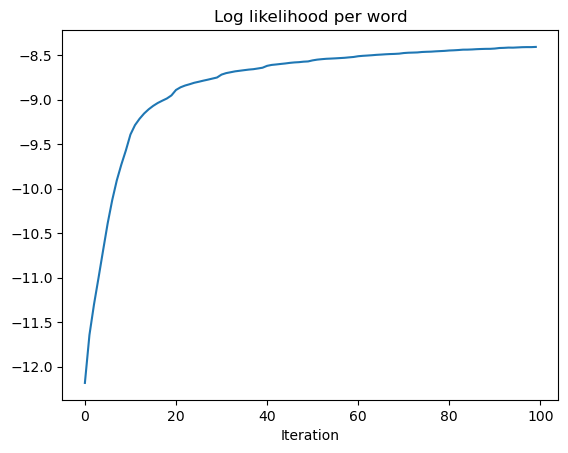

In [132]:
iterations = [i for i in range(100)]
plt.plot(iterations, loss)
plt.title("Log likelihood per word")
plt.xlabel("Iteration")
plt.show()

In [140]:
# train accuracy
labels = [ ]
for i in range(train.shape[0]):
    new_doc = model.make_doc(train["text_cleaned"][i].split())
    model.infer(new_doc)
    p = model.estimate(new_doc)
    labels.append(np.argmax(p))

accuracy_metrics(labels, y_train)

accuracy 0.5035
              precision    recall  f1-score   support

           0       0.54      0.34      0.42        80
           1       0.76      0.91      0.83        80
           2       0.71      0.60      0.65        80
           3       0.51      0.79      0.62        80
           4       0.52      0.16      0.25        80
           5       0.52      0.62      0.56        80
           6       0.58      0.09      0.15        80
           7       0.75      0.64      0.69        80
           8       0.49      0.42      0.46        80
           9       0.48      0.74      0.58        80
          10       0.34      0.38      0.36        80
          11       0.40      0.75      0.52        80
          12       0.26      0.40      0.32        80
          13       0.60      0.66      0.63        80
          14       0.20      0.01      0.02        80
          15       0.00      0.00      0.00        80
          16       0.46      0.56      0.51        80
          1

/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# val accuracy
labels = [ ]
for i in range(val.shape[0]):
    new_doc = model.make_doc(val["text_cleaned"][i].split())
    model.infer(new_doc)
    p = model.estimate(new_doc)
    labels.append(np.argmax(p))

accuracy_metrics(labels, y_val)

In [141]:
# test accuracy
labels = [ ]
for i in range(test.shape[0]):
    new_doc = model.make_doc(test["text_cleaned"][i].split())
    model.infer(new_doc)
    p = model.estimate(new_doc)
    labels.append(np.argmax(p))

accuracy_metrics(labels, y_test)

accuracy 0.48
              precision    recall  f1-score   support

           0       0.43      0.30      0.35        10
           1       0.90      0.90      0.90        10
           2       0.67      0.40      0.50        10
           3       0.38      0.50      0.43        10
           4       0.50      0.20      0.29        10
           5       0.54      0.70      0.61        10
           6       0.00      0.00      0.00        10
           7       0.75      0.60      0.67        10
           8       0.56      0.50      0.53        10
           9       0.38      0.50      0.43        10
          10       0.35      0.60      0.44        10
          11       0.44      0.80      0.57        10
          12       0.20      0.20      0.20        10
          13       0.62      0.50      0.56        10
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        10
          16       0.38      0.60      0.46        10
          17 

/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [146]:
# Return the number of words allocated to each topic.
counts = model.get_count_by_topics()
for i in range(46):
    print(f'Topic {i+1}: {counts[i]} words')

Topic 1: 14896 words
Topic 2: 31033 words
Topic 3: 6316 words
Topic 4: 38690 words
Topic 5: 21159 words
Topic 6: 21698 words
Topic 7: 15584 words
Topic 8: 16218 words
Topic 9: 36162 words
Topic 10: 16669 words
Topic 11: 39170 words
Topic 12: 10370 words
Topic 13: 25935 words
Topic 14: 77358 words
Topic 15: 16403 words
Topic 16: 24160 words
Topic 17: 5476 words
Topic 18: 16188 words
Topic 19: 11239 words
Topic 20: 18087 words
Topic 21: 25398 words
Topic 22: 33133 words
Topic 23: 12829 words
Topic 24: 25364 words
Topic 25: 15439 words
Topic 26: 16604 words
Topic 27: 36451 words
Topic 28: 15457 words
Topic 29: 17830 words
Topic 30: 25495 words
Topic 31: 8924 words
Topic 32: 35937 words
Topic 33: 41110 words
Topic 34: 16808 words
Topic 35: 10838 words
Topic 36: 15955 words
Topic 37: 30120 words
Topic 38: 9448 words
Topic 39: 17151 words
Topic 40: 24809 words
Topic 41: 6389 words
Topic 42: 18357 words
Topic 43: 37316 words
Topic 44: 25589 words
Topic 45: 20615 words
Topic 46: 15044 words


In [145]:
# Return the top_n words and its probability in the topic topic_id
for i in range(46):
    print(f'Topic {i+1}')
    words = model.get_topic_words(i, top_n=10)
    for word in words:
        print(word[0])
    print('\n')

Topic 1
court
wang
dissident
case
right
appeal
former
trial
government
prison


Topic 2
hong
kong
tung
chinese
british
territory
handover
beijing
legislature
britain


Topic 3
property
beer
bass
group
merger
optus
suez
brewer
foster
lyonnaise


Topic 4
business
executive
also
chief
unit
make
firm
plan
product
industry


Topic 5
thomson
french
franc
boeing
france
billion
airbus
sale
defence
group


Topic 6
plant
ford
worker
strike
vehicle
chrysler
truck
union
automaker
motor


Topic 7
apple
computer
technology
intel
chip
machine
corp
based
system
product


Topic 8
internet
service
online
network
access
plan
site
auction
america
user


Topic 9
state
government
foreign
problem
could
official
billion
rule
industry
money


Topic 10
czech
crown
prague
klaus
billion
deficit
central
trade
bank
first


Topic 11
executive
first
time
chief
city
people
former
shanghai
month
like


Topic 12
colombia
drug
army
guerrilla
military
force
colombian
liberte
government
rebel


Topic 13
pound
penny
british

# analysis

In [169]:
# accuracy by author
authors = [i for i in range(50)]
train_accuracy = [ ]
test_accuracy = [ ]

for i in range(50):
    author = i
    train_i = train[train["author_id"] == author]
    test_i = test[test["author_id"] == author]
    
    # train accuracy
    train_labels = [ ]
    for index, row in train_i.iterrows():
        new_doc = model.make_doc(row["text_cleaned"].split())
        model.infer(new_doc)
        p = model.estimate(new_doc)
        train_labels.append(np.argmax(p))

    y_true = train_i["author_id"].to_numpy()
    train_accuracy.append(accuracy_score(y_true, train_labels))
    
    # test accuracy
    test_labels = [ ]
    for index, row in test_i.iterrows():
        new_doc = model.make_doc(row["text_cleaned"].split())
        model.infer(new_doc)
        p = model.estimate(new_doc)
        test_labels.append(np.argmax(p))
    
    y_true = test_i["author_id"].to_numpy()
    test_accuracy.append(accuracy_score(y_true, test_labels))


In [173]:
pd.options.display.float_format = "{:,.4f}".format

In [175]:
result = pd.DataFrame(data = {"Author": authors, "Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy})
result

,Author,Train Accuracy,Test Accuracy
0,0,0.3375,0.3000
1,1,0.9125,0.9000
2,2,0.6000,0.4000
3,3,0.7875,0.5000
4,4,0.1625,0.2000
5,5,0.6250,0.7000
6,6,0.0875,0.0000
7,7,0.6375,0.6000
8,8,0.4250,0.5000
9,9,0.7375,0.5000


In [221]:
test[test["author_id"] == ]

,author_id,text,text_cleaned,predicted_label
390,38,British life assurer Scottish Amicable said on...,british life assurer scottish amicable said th...,38
391,38,Lloyd's of London announced on Tuesday it is t...,lloyd london announced tuesday give name time ...,38
392,38,Composite insurer Royal &amp; Sun Alliance Gro...,composite insurer royal alliance group thursda...,38
393,38,Britain's NatWest Group said on Thursday it wa...,britain natwest group said thursday setting bu...,0
394,38,"Britain's United Assurance Group, created by t...",britain united assurance group created merger ...,38
395,38,British composite insurer Commercial Union Plc...,british composite insurer commercial union tue...,0
396,38,British insurance group Norwich Union said on ...,british insurance group norwich union said tue...,38
397,38,Insurance group Guardian Royal Exchange Plc on...,insurance group guardian royal exchange tuesda...,38
398,38,Britain's Ladbroke Group Plc Monday concluded ...,britain ladbroke group monday concluded long a...,11
399,38,"International insurance broker Willis Corroon,...",international insurance broker willis corroon ...,38


author_id                                                         38
text               Britain's NatWest Group said on Thursday it wa...
text_cleaned       britain natwest group said thursday setting bu...
predicted_label                                                    0
Name: 393, dtype: object

In [202]:
# average topic distribution by author
avg_topic_dist = [ ]
for i in range(50):
    author = i
    train_i = train[train["author_id"] == author]
    
    topic_dist_i = [ ]
    for index, row in train_i.iterrows():
        new_doc = model.make_doc(row["text_cleaned"].split())
        vals = model.infer(new_doc)[0]
        topic_dist_i.append(vals)
    
    avg_topic_dist.append(np.array(topic_dist_i).mean(axis=0))

In [224]:
new_doc = model.make_doc(test.loc[393]["text_cleaned"].split())
doc_vals = model.infer(new_doc)[0]

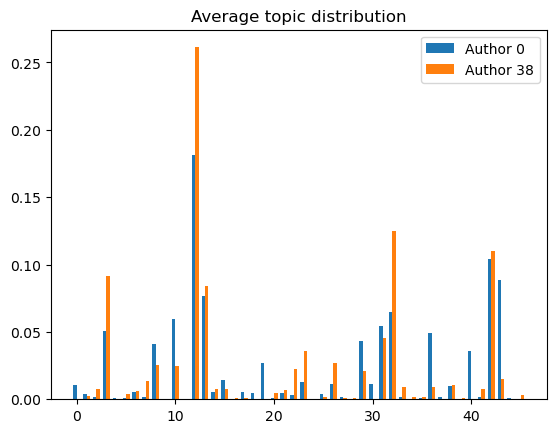

In [278]:
# Width of each bar
bar_width = 0.35

groups = [i for i in range(1,47)]
values1 = avg_topic_dist[0]
values2 = avg_topic_dist[38] # doc_vals # 

# Create an array of x positions for the bars
x = np.arange(len(groups))

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the first set of bars
rects1 = ax.bar(x - bar_width/2, values1, bar_width, label='Author 0')

# Plot the second set of bars
rects2 = ax.bar(x + bar_width/2, values2, bar_width, label='Author 38')

# Add labels and title
# ax.set_ylabel('Topic probability')
ax.set_title('Average topic distribution')
ax.legend()

# plt.savefig('author_3_4.png') 

# Show the plot
plt.show()

In [244]:
test[test["author_id"] == 35]

,author_id,text,text_cleaned,predicted_label
250,35,Chinese zinc producers are expected to take ad...,chinese zinc producer expected take advantage ...,35
251,35,China's role as an important world trading par...,china role important world trading partner leg...,35
252,35,China is awash with steel and suppliers scramb...,china awash steel supplier scrambling piece wo...,35
253,35,Smiles are coming back to the faces of Asian s...,smile coming back face asian sugar trader indu...,35
254,35,The rise in the London Metal Exchange (LME) zi...,rise london metal exchange zinc price five mon...,35
255,35,Wheat is unlikely to become a casualty of the ...,wheat unlikely become casualty beijing washing...,35
256,35,World zinc prices that have risen to levels no...,world zinc price risen level seen four year go...,35
257,35,China has given the green light to corn export...,china given green light corn export minimum se...,35
258,35,Sugar producers in China are worried that a fl...,sugar producer china worried flood import coul...,35
259,35,Far East metals traders were preoccupied with ...,east metal trader preoccupied question monday ...,35


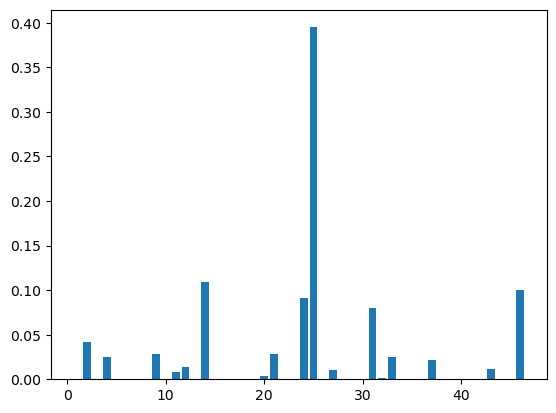

In [248]:
topics = [i for i in range(1,47)]
new_doc = model.make_doc(test["text_cleaned"][253].split())
vals = model.infer(new_doc)[0]
plt.bar(topics, vals)
plt.show()

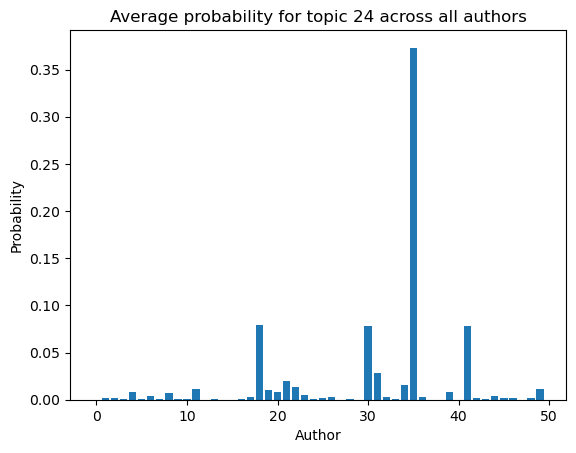

In [276]:
plt.bar([i for i in range(50)], np.array(avg_topic_dist)[:,24])
plt.title("Average probability for topic 24 across all authors")
plt.xlabel("Author")
plt.ylabel("Probability")
plt.savefig('author_35_topic_24.png') 
plt.show()

In [273]:
avg_topic_dist[20].sum()

1.0

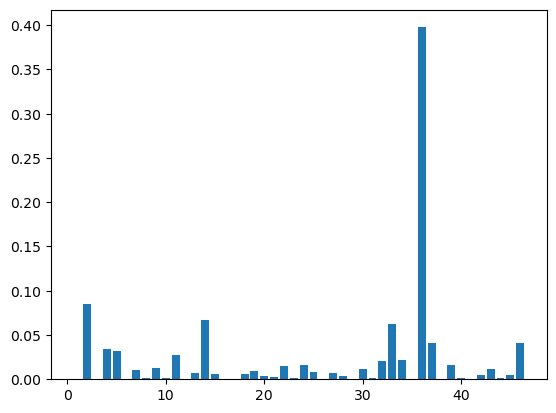

In [268]:
topics = [i for i in range(1,47)]
vals = avg_topic_dist[20]
plt.bar(topics, vals)
plt.show()

In [183]:
train_labels = [ ]
for i in range(train.shape[0]):
    new_doc = model.make_doc(train["text_cleaned"][i].split())
    model.infer(new_doc)
    p = model.estimate(new_doc)
    train_labels.append(np.argmax(p))

accuracy_metrics(train_labels, y_train)

accuracy 0.5035
              precision    recall  f1-score   support

           0       0.54      0.34      0.42        80
           1       0.76      0.91      0.83        80
           2       0.71      0.60      0.65        80
           3       0.51      0.79      0.62        80
           4       0.52      0.16      0.25        80
           5       0.52      0.62      0.56        80
           6       0.58      0.09      0.15        80
           7       0.75      0.64      0.69        80
           8       0.49      0.42      0.46        80
           9       0.48      0.74      0.58        80
          10       0.34      0.38      0.36        80
          11       0.40      0.75      0.52        80
          12       0.26      0.40      0.32        80
          13       0.60      0.66      0.63        80
          14       0.20      0.01      0.02        80
          15       0.00      0.00      0.00        80
          16       0.46      0.56      0.51        80
          1

/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [213]:
avg_topic_dist = [ ]
for i in range(50):
    author = i
    test_i = test[test["author_id"] == author]
    
    topic_dist_i = [ ]
    for index, row in test_i.iterrows():
        new_doc = model.make_doc(row["text_cleaned"].split())
        vals = model.infer(new_doc)[0]
        topic_dist_i.append(vals)
    
    avg_topic_dist.append(np.array(topic_dist_i).mean(axis=0))
    

for i in range(50):
    author = i
    test_i = test[test["author_id"] == author]
    
    test_labels = [ ]
    for index, row in test_i.iterrows():
        new_doc = model.make_doc(row["text_cleaned"].split())
        model.infer(new_doc)
        p = model.estimate(new_doc)
        test_labels.append(np.argmax(p))
    
    # mode = statistics.mode(test_labels)
    
    label_counts = dict()
    for lab in test_labels:
        if lab not in label_counts.keys(): 
            label_counts[lab] = 0
        label_counts[lab] += 1
    
    
    print(f'Author {i}: {str(label_counts)}')

Author 0: {24: 1, 0: 3, 27: 1, 38: 2, 37: 1, 23: 2}
Author 1: {1: 9, 18: 1}
Author 2: {34: 2, 2: 4, 29: 1, 48: 1, 46: 1, 44: 1}
Author 3: {3: 5, 11: 1, 43: 1, 4: 2, 16: 1}
Author 4: {3: 7, 4: 2, 34: 1}
Author 5: {5: 7, 24: 1, 6: 1, 31: 1}
Author 6: {31: 2, 33: 1, 3: 1, 0: 1, 24: 2, 20: 1, 38: 1, 43: 1}
Author 7: {7: 6, 28: 1, 41: 1, 11: 2}
Author 8: {8: 5, 30: 1, 26: 2, 22: 1, 45: 1}
Author 9: {12: 1, 10: 4, 9: 5}
Author 10: {10: 6, 12: 1, 9: 3}
Author 11: {11: 8, 16: 1, 43: 1}
Author 12: {10: 5, 9: 1, 12: 2, 40: 1, 44: 1}
Author 13: {13: 5, 34: 1, 25: 4}
Author 14: {12: 2, 16: 4, 9: 1, 10: 1, 28: 1, 5: 1}
Author 15: {24: 4, 20: 3, 47: 1, 30: 1, 40: 1}
Author 16: {16: 6, 36: 2, 28: 1, 11: 1}
Author 17: {17: 5, 31: 2, 9: 1, 20: 1, 22: 1}
Author 18: {18: 8, 35: 1, 21: 1}
Author 19: {26: 6, 19: 1, 22: 1, 8: 1, 28: 1}
Author 20: {20: 10}
Author 21: {29: 6, 22: 1, 21: 2, 35: 1}
Author 22: {22: 8, 20: 1, 18: 1}
Author 23: {23: 7, 27: 1, 22: 1, 40: 1}
Author 24: {24: 4, 44: 1, 27: 1, 47: 1, 2

In [215]:
# test labels
labels = [ ]
for i in range(test.shape[0]):
    new_doc = model.make_doc(test["text_cleaned"][i].split())
    model.infer(new_doc)
    p = model.estimate(new_doc)
    labels.append(np.argmax(p))
test["predicted_label"] = labels

In [216]:
# train labels
labels = [ ]
for i in range(train.shape[0]):
    new_doc = model.make_doc(train["text_cleaned"][i].split())
    model.infer(new_doc)
    p = model.estimate(new_doc)
    labels.append(np.argmax(p))
train["predicted_label"] = labels

In [217]:
# val labels
labels = [ ]
for i in range(val.shape[0]):
    new_doc = model.make_doc(val["text_cleaned"][i].split())
    model.infer(new_doc)
    p = model.estimate(new_doc)
    labels.append(np.argmax(p))
val["predicted_label"] = labels